# e4e setup, run once only!

In [1]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.5MB/s eta 0:03:33tcmalloc: large alloc 1147494400 bytes == 0x56492b20a000 @  0x7f6b8a36b615 0x5648f125206c 0x5648f1331eba 0x5648f1254e8d 0x5648f134699d 0x5648f12c8fe9 0x5648f12c3b0e 0x5648f125677a 0x5648f12c8e50 0x5648f12c3b0e 0x5648f125677a 0x5648f12c586a 0x5648f13477c6 0x5648f12c4ee2 0x5648f13477c6 0x5648f12c4ee2 0x5648f13477c6 0x5648f12c4ee2 0x5648f13477c6 0x5648f13c9431 0x5648f132a049 0x5648f1294c84 0x5648f12558e9 0x5648f12c9ade 0x5648f125669a 0x5648f12c4a45 0x5648f12c3e0d 0x5648f125677a 0x5648f12c4a45 0x5648f125669a 0x5648f12c4a45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:25tcmalloc: large alloc 1434370048 bytes == 0x56496f860000 @  0x7f6b8a36b615 0x5648f125206c 0x5648f1331eba 0x5648f1254e8d 0x5648f134699d 0x5648f12c8fe9 0x5648f12c3b0e 0x5648f125677a 0x5648f12c8e50 0x5648f12c3b0e 0x5648f125677a 0x5648f12c586a 0x5648

In [ ]:
#@title
experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

--2021-04-19 03:49:41--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-04-19 03:49:41--  https://docs.google.com/uc?export=download&confirm=ka9P&id=1cUv_reLE6k3604or78EranS7XzuVMWeO
Resolving docs.google.com (docs.google.com)... 142.250.73.238, 2607:f8b0:4004:807::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-48-docs.googleusercontent.com/docs/securesc/pb2ognvp8hvtv0ue0b12a5igfa0aoqt4/tf1pplidjtfrmcdbqbbe7n49t9hv0j8q/1618804125000/16870642656286163956/03822639630143588889Z/1cUv_reLE6k3604or78EranS7XzuVMWeO?e=download [following]
--2021-04-19 03:49:42--  https://doc-04-48-docs.googleusercontent.com/docs/securesc/pb2ognvp8hvtv0ue0b12a5igfa0aoqt4/tf1pplidjtfrmcdbqbbe7n49t9hv0j8q/1618804125000/16870642656286163956/03822639630143588889Z/1cUv_reLE6k3604or78EranS7XzuVMWeO?e=download
Resolvi

# Input Image

In [23]:
#@markdown Upload an image to the encoder4editing folder and set the image_name into the image name
image_name = 'elon1.jpg' #@param {type:"string"}
os.chdir('/content/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_name
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

# e4e completion

In [24]:
#@title
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


Aligned image has shape: (256, 256)


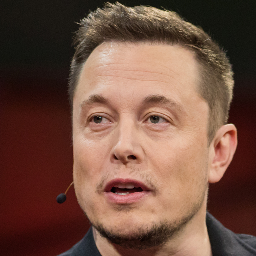

In [25]:
#@title
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

Inference took 0.1454 seconds.


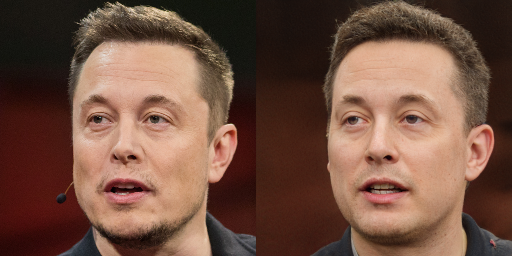

In [26]:
#@title
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

In [27]:
torch.save(latents, 'latents.pt')

# StyleCLIP setup, run once only!

In [8]:
%cd
%cd /content/


! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/bycloudai/StyleCLIP

dataset_name='ffhq'
# input dataset name 

%cd
%cd /content/StyleCLIP/global/
# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

os.chdir('/content/StyleCLIP/global/')

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

/root
/content
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=43e8e8e44a37ea0643f2ffe666b6cf9dbae77fd5e726cef1e68eecd2c4ce43fa
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0cca5h8z
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-0cca5h8z
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368708 sha256=2cec13a6c32fe736d15f328c2a0d86befc41254fd5c529bc09155f3b19fcb022
  Stored in directory: /tmp/pip-ephem-wheel-cache-lpw_f_wa/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
Successfully built clip
Cloning into 'StyleCLIP'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 533 (delt

100%|███████████████████████████████████████| 354M/354M [00:03<00:00, 96.4MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (?, 512)             (512, 

# StyleCLIP Body

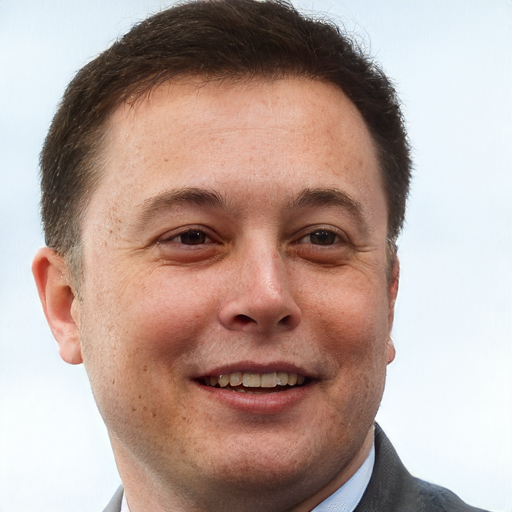

In [9]:
latents=torch.load('/content/encoder4editing/latents.pt') # located in the top-level folder in the Colab UI
w_plus=latents.cpu().detach().numpy()
dlatents_loaded=M.W2S(w_plus)

img_index = 0
img_indexs=[img_index]

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0, dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

# input text description 
"Neural" should describe the original image
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |

In [21]:
neutral='face' #@param {type:"string"}
target='cute eyes' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.4265


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 113


(-0.5, 1023.5, 1023.5, -0.5)

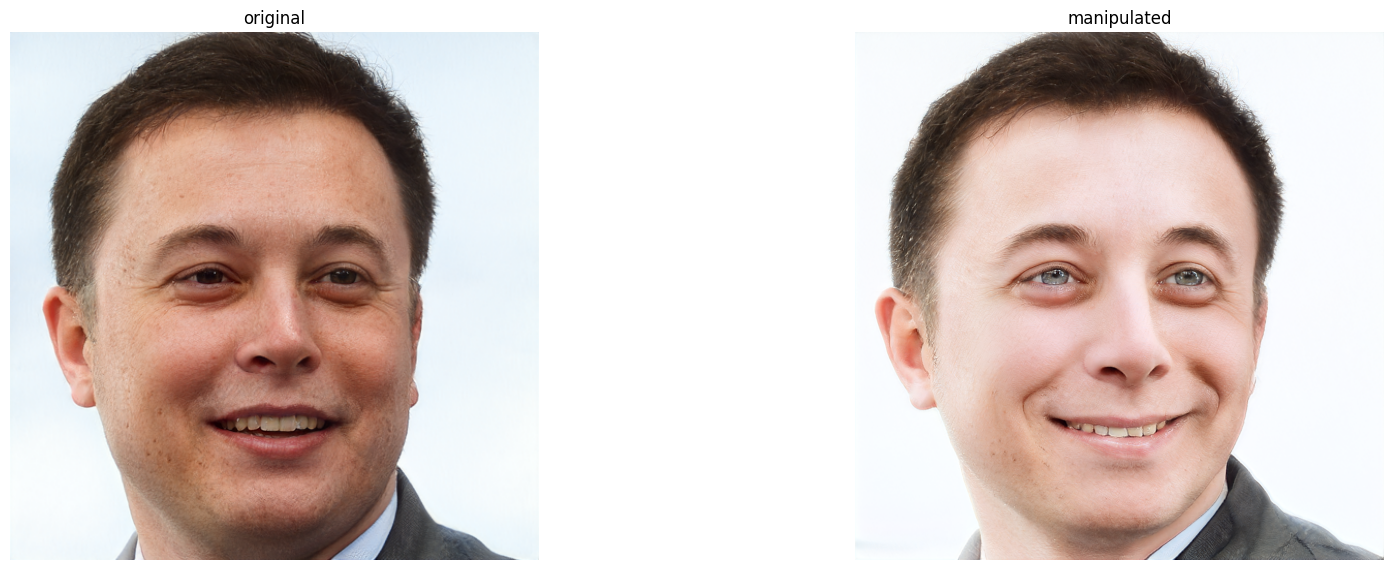

In [25]:

#beta=0.1
#alpha=1
beta = 0.08 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 6.2 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')